### The model (one step reward)

$u(c) = log(c+1)$ utility function    
$y = 1$ Deterministic income    
$p(r = 0.02) = 0.5$   
$p(r = -0.01) = 0.5$ 

Explicit form of policy is linear:
$$ c(w) = \frac{y+w}{2 \beta +1} = 0.3448275862068966 + 0.3448275862068966 w$$

In [1]:
# infinite horizon MDP problem
%pylab inline
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# discounting factor 
beta = 0.95
# wealth level
eps = 0.001
w_low = eps
w_high = 10
# interest rate
r_up = 0.02
r_down = 0.01
# deterministic income
y = 1
# good state and bad state economy with equal probability 0.5
# with good investment return 0.02 or bad investment return -0.01
ws = np.linspace(w_low, w_high**(0.5),100)**2
Vs = np.zeros(100)
Cs = np.zeros(100)

def u(c):
    return np.log(c)

def uB(b):
    B = 2
    return B*u(b)

Populating the interactive namespace from numpy and matplotlib


In [2]:
for i in range(len(ws)):
    w = ws[i]
    def obj(c):
        return -(u(c) + beta*(uB((y+w-c)*(1+r_up)) + uB(y+w-c)*(1-r_down))/2)
    bounds = [(eps, y+w-eps)]
    res = minimize(obj, eps, method='SLSQP', bounds=bounds)
    Cs[i] = res.x[0]
    Vs[i] = -res.fun

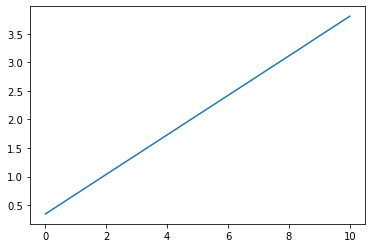

In [3]:
plt.plot(ws, Cs)

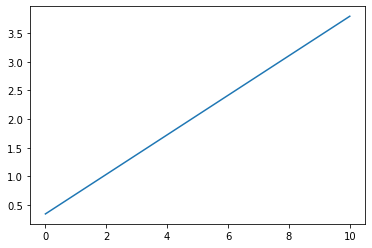

In [4]:
plt.plot(ws,(1+ws)/(2*beta+1))

### policy gradient
Assume the policy form $\theta = (a,b, \sigma = 0.1)$, then $\pi_\theta$ ~ $N(ax+b, \sigma)$

Assume the initial value $a = 1$, $b = 1$, $\sigma = 0.1$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [10]:
T = 1
# simulation step T = 100
def poly(theta, w):
    return theta[0] * w + theta[1] 

def mu(theta, w):
    return poly(theta, w)

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.uniform(w_low, w_high)
    for t in range(T):
        n = np.random.normal(mu(theta, w), theta[-1])
        n = max(min(n, 1-eps), eps)
        c = (w+y) * n
        wPath[t] = w
        aPath[t] = n
        rPath[t] = u(c)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
            rPath[t] += beta*uB(w)
        else:
            w = (w+y-c) * (1-r_down)
            rPath[t] += beta*uB(w)
    return wPath, aPath, rPath



def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            newGrad[0] = np.sum((ap - mu(theta, wp))*(wp))
            newGrad[1] = np.sum((ap - mu(theta, wp))*(1))
            grad += newGrad * np.sum(rp)
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 

def plot3(theta):
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, mu(theta, ws), 'r')

0
[0, 0, 0.3]
100
[0.04532232 0.08363118 0.3       ]
200
[0.03641582 0.16157777 0.3       ]
300
[0.0281432  0.22919079 0.3       ]
400
[0.01806464 0.2779111  0.3       ]
500
[0.01496238 0.30871073 0.3       ]
600
[0.00807066 0.3319175  0.3       ]
700
[0.00806936 0.35545863 0.3       ]
800
[0.01103691 0.36212541 0.3       ]
900
[0.00418975 0.36039215 0.3       ]
1000
[0.01083371 0.36142188 0.3       ]
1100
[0.00238825 0.36823107 0.3       ]
1200
[0.00116869 0.37056435 0.3       ]
1300
[-0.0079872   0.36915866  0.3       ]
1400
[0.00955881 0.37050915 0.3       ]
1500
[-0.00371271  0.37682572  0.3       ]
1600
[0.0089678  0.37127182 0.3       ]
1700
[-0.01511444  0.37175924  0.3       ]
1800
[0.01068153 0.36403785 0.3       ]
1900
[-0.00431524  0.36990775  0.3       ]


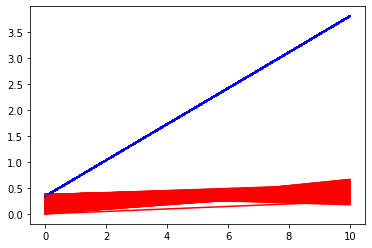

In [19]:
# initial theta
N = 2000
theta = [0,0,0.3]
# gradient ascend step size 
alpha = 0.01
# store theta
THETA3 = np.zeros((len(theta)-1,N))
for i in range(N):
    if i%100 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA3[:,i] = theta[:len(theta)-1]
    plot3(theta)

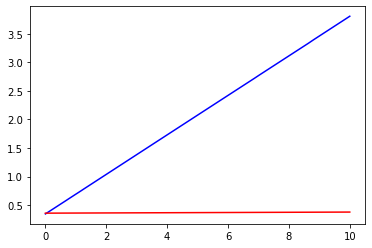

In [20]:
plot3(theta)